# Dataset
Dataset yang diambil untuk project ini merupakan dataset bank marketing campaign dimana bank memiliki sistem dimana pelanggan / client akan menyimpan uang pada bank dimana bank akan memberikan bunga fixed pada pelanggan tersebut. Terdapat beberapa bank sehingga hal ini menimbulkan sebuah persaingan antar bank untuk menjaga customer / client agar tetap melakukan deposit pada bank tersebut sehingga dilakukan bank marketing campaign untuk meminimalisir terjadinya kehilangan customer / client. Berikut merupakan penjelasan sekilas dari data yang terdapat pada dataset ini.

Feature
* `age` : Umur dari pelanggan
* `job` : Bidang pekerjaan pelanggan
* `balance` : Jumlah rekening bank dari pelanggan
* `housing` : Customer sedang memiliki cicilan rumah atau tidak
* `loan` : Customer sedang memiliki utang atau tidak
* `contact`: Tipe komunikasi kontak.
* `month`: Bulan terakhir contact.
* `campaign`: Jumlah kontak dilakukan pada campaign ini.
* `pdays`: Jumlah hari setelah client dikontak dari campaign sebelumnya.
* `poutcome`: Outcome dari marketing campaign sebelumnya.

Target
* `deposit`: Apakah customer melakukan deposit atau tidak.

Dari tujuan yang ingin dicapai oleh bank marketing campaign, maka penelitian ini akan difokuskan untuk memodelkan sebuah model machine learning yang dapat melakukan prediksi mengenai apakah customer akan melakukan deposit atau tidak berdasarkan feature yang ada dimana hal ini dapat dijadikan sebagai basis untuk bank dalam memberikan perlakuan pada customer. Seperti contohnya, pelanggan yang diprediksikan tidak melakukan deposit mungkin dapat diberikan perlakuan khusus agar customer tersebut tetap melakukan deposit atau hal lain semacam ini.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing & feature engineering
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer,MissingIndicator
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, SelectFromModel, RFE

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Model validation & evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, f1_score

# Pipeline
from sklearn.pipeline import Pipeline
import warnings
import category_encoders as ce

In [2]:
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('data_bank_marketing_campaign.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813 entries, 0 to 7812
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       7813 non-null   int64 
 1   job       7813 non-null   object
 2   balance   7813 non-null   int64 
 3   housing   7813 non-null   object
 4   loan      7813 non-null   object
 5   contact   7813 non-null   object
 6   month     7813 non-null   object
 7   campaign  7813 non-null   int64 
 8   pdays     7813 non-null   int64 
 9   poutcome  7813 non-null   object
 10  deposit   7813 non-null   object
dtypes: int64(4), object(7)
memory usage: 671.6+ KB


In [4]:
df.isna().sum()

age         0
job         0
balance     0
housing     0
loan        0
contact     0
month       0
campaign    0
pdays       0
poutcome    0
deposit     0
dtype: int64

Tidak ada missing data yang ditemukan

In [5]:
df.head()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no


In [6]:
df.describe()

,age,balance,campaign,pdays
count,7813.000000,7813.000000,7813.000000,7813.000000
mean,41.257264,1512.448611,2.519775,51.408550
std,11.919710,3089.291831,2.727001,108.072739
min,18.000000,-6847.000000,1.000000,-1.000000
25%,32.000000,127.000000,1.000000,-1.000000
50%,39.000000,549.000000,2.000000,-1.000000
75%,49.000000,1684.000000,3.000000,40.000000
max,95.000000,66653.000000,63.000000,854.000000


In [7]:
numerical_cols = df.select_dtypes(include=['int']).columns
for i in numerical_cols:
    if i == 'deposit':
        break

    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[i] < (Q1 - 1.5 * IQR)) | (df[i] > (Q3 + 1.5 * IQR)))
    print(f"Number of outlier in column {i} : {len(df[i].loc[outliers])}")

Number of outlier in column age : 121
Number of outlier in column balance : 736
Number of outlier in column campaign : 429
Number of outlier in column pdays : 1454


Dari data ini, terdapat beberapa outlier yang ditemukan namun data outlier ini dapat dipertahankan karena akan diberikan perlakuan menggunakan RobustScaler untuk melakukan normalisasi data

# Data Preprocessing & Feature Engineering

In [8]:
print(df['campaign'].min())
print(df['campaign'].max())
print(df['campaign'].mean())

1
63
2.5197747344169974


In [9]:
def contact_frequency(x):
    if x > 0 and x < 3:
        return "Rarely Contacted"
    elif x >= 3 and x <= 5:
        return "Moderately Contacted"
    else:
        return "Frequently Contacted"

In [10]:
df['contact_frequency'] = df['campaign'].apply(contact_frequency)

In [11]:
df.head()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit,contact_frequency
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes,Rarely Contacted
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes,Moderately Contacted
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes,Rarely Contacted
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no,Rarely Contacted
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no,Moderately Contacted


In [12]:
df['pdays'] = df['pdays'].apply(lambda x : 0 if x == -1 else x)

-1 in pdays mengartikan customer diasumsikan tidak dicontact pada campaign sebelumnya atau baru dicontact hari ini sehingga dapat diartikan bahwa pdays dengan value -1 sama dengan 0

In [13]:
print(df['age'].min())
print(df['age'].mean())
print(df['age'].max())

18
41.25726353513375
95


In [14]:
bin_edges = range(18, 100, 5) 
labels = [f"{start} - {start + 4}" for start in bin_edges[:-1]]
df['age_interval'] = pd.cut(df['age'], bins=bin_edges, labels=labels, right=False)

In [15]:
df.head()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit,contact_frequency,age_interval
0,55,admin.,1662,no,no,cellular,jun,2,0,unknown,yes,Rarely Contacted,53 - 57
1,39,self-employed,-3058,yes,yes,cellular,apr,3,0,unknown,yes,Moderately Contacted,38 - 42
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes,Rarely Contacted,48 - 52
3,38,services,-87,yes,no,cellular,may,1,0,unknown,no,Rarely Contacted,38 - 42
4,36,housemaid,205,yes,no,telephone,nov,4,0,unknown,no,Moderately Contacted,33 - 37


<AxesSubplot:xlabel='deposit', ylabel='count'>

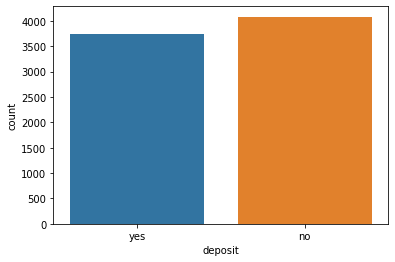

In [16]:
sns.countplot(df['deposit'])

Tidak ada perbedaan signifikan antara data yes dan no pada kolom `deposit` sehingga dapat diasumsikan bahwa data ini masih termasuk balanced

In [17]:
df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

In [18]:
df.head()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit,contact_frequency,age_interval
0,55,admin.,1662,no,no,cellular,jun,2,0,unknown,1,Rarely Contacted,53 - 57
1,39,self-employed,-3058,yes,yes,cellular,apr,3,0,unknown,1,Moderately Contacted,38 - 42
2,51,admin.,3025,no,no,cellular,may,1,352,other,1,Rarely Contacted,48 - 52
3,38,services,-87,yes,no,cellular,may,1,0,unknown,0,Rarely Contacted,38 - 42
4,36,housemaid,205,yes,no,telephone,nov,4,0,unknown,0,Moderately Contacted,33 - 37


In [19]:
df['debt'] = ((df['loan'] == 'yes') | (df['housing'] == 'yes')).astype(int)

In [20]:
df['debt'].value_counts()

1    4090
0    3723
Name: debt, dtype: int64

Kategori masih bisa digolongkan sedikit sehingga digunakan one hot encoding

In [21]:
df['poutcome'].value_counts()

unknown    5819
failure     848
success     761
other       385
Name: poutcome, dtype: int64

Kategori masih bisa digolongkan sedikit sehingga digunakan one hot encoding

In [22]:
df['difference_balance_and_average'] = np.abs(df['balance'] - df['balance'].mean())

In [23]:
df.head()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit,contact_frequency,age_interval,debt,difference_balance_and_average
0,55,admin.,1662,no,no,cellular,jun,2,0,unknown,1,Rarely Contacted,53 - 57,0,149.551389
1,39,self-employed,-3058,yes,yes,cellular,apr,3,0,unknown,1,Moderately Contacted,38 - 42,1,4570.448611
2,51,admin.,3025,no,no,cellular,may,1,352,other,1,Rarely Contacted,48 - 52,0,1512.551389
3,38,services,-87,yes,no,cellular,may,1,0,unknown,0,Rarely Contacted,38 - 42,1,1599.448611
4,36,housemaid,205,yes,no,telephone,nov,4,0,unknown,0,Moderately Contacted,33 - 37,1,1307.448611


In [24]:
df['job'].value_counts()

management       1792
blue-collar      1346
technician       1291
admin.            936
services          658
retired           540
self-employed     280
unemployed        249
student           247
entrepreneur      236
housemaid         184
unknown            54
Name: job, dtype: int64

Digunakan binary encoding karena jumlah kategori digolongkan cukup banyak

In [25]:
df['housing'].value_counts()

no     4140
yes    3673
Name: housing, dtype: int64

Kategori masih bisa digolongkan sedikit sehingga digunakan one hot encoding

In [26]:
df['loan'].value_counts()

no     6789
yes    1024
Name: loan, dtype: int64

Kategori masih bisa digolongkan sedikit sehingga digunakan one hot encoding

In [27]:
df['contact'].value_counts()

cellular     5628
unknown      1639
telephone     546
Name: contact, dtype: int64

Kategori masih bisa digolongkan sedikit sehingga digunakan one hot encoding

In [28]:
df['month'].value_counts()

may    1976
aug    1085
jul    1050
jun     857
apr     662
nov     657
feb     534
oct     286
jan     227
sep     212
mar     199
dec      68
Name: month, dtype: int64

Kategori banyak dan memiliki jarak yang pasti tiap bulannya sehingga digunakan ordinal encoding

# Creating Interaction Feature

In [ ]:
df['poutcome_month'] = df['poutcome'] + '_' + df['month']

In [ ]:
df['poutcome_month'].value_counts()

unknown_may    1546
unknown_jul     942
unknown_aug     889
unknown_jun     734
unknown_nov     443
unknown_apr     434
unknown_feb     317
failure_may     243
unknown_jan     146
unknown_oct     134
unknown_mar     127
failure_apr     122
failure_nov     115
success_may     102
success_aug     101
failure_feb      93
other_may        85
unknown_sep      84
success_feb      80
success_oct      75
success_sep      74
success_jun      66
success_nov      66
failure_aug      64
success_apr      57
success_jul      52
failure_oct      51
other_apr        49
other_feb        44
success_mar      34
failure_jul      34
failure_sep      33
failure_jun      33
other_nov        33
other_aug        31
failure_jan      28
success_jan      28
other_oct        26
success_dec      26
other_jan        25
other_jun        24
unknown_dec      23
other_jul        22
other_sep        21
failure_mar      21
other_mar        17
failure_dec      11
other_dec         8
Name: poutcome_month, dtype: int64

In [ ]:
df['age_job'] = df['age'].astype(str) + '_' + df['job']

In [ ]:
df['age_job'].value_counts()

31_management      100
30_management       97
33_management       93
35_management       93
32_management       92
                  ... 
39_unknown           1
65_entrepreneur      1
21_admin.            1
22_unemployed        1
36_unknown           1
Name: age_job, Length: 505, dtype: int64

In [ ]:
df['contact_month'] = df['contact'] + '_' + df['month']

In [ ]:
df['contact_month'].value_counts()

cellular_aug     1041
unknown_may       988
cellular_may      910
cellular_jul      892
cellular_apr      615
cellular_nov      576
unknown_jun       566
cellular_feb      478
cellular_jun      275
cellular_oct      219
cellular_jan      202
cellular_sep      184
cellular_mar      178
telephone_jul     129
telephone_may      78
telephone_nov      67
cellular_dec       58
telephone_feb      53
telephone_oct      52
telephone_apr      43
telephone_aug      35
unknown_jul        29
telephone_jan      25
telephone_sep      19
telephone_mar      19
telephone_jun      16
unknown_oct        15
unknown_nov        14
telephone_dec      10
unknown_sep         9
unknown_aug         9
unknown_apr         4
unknown_feb         3
unknown_mar         2
Name: contact_month, dtype: int64

In [ ]:
df['balance_age_ratio'] = df['balance'] / df['age']

In [ ]:
df['campaign_pdays'] = (df['campaign'] * -1) * df['pdays']

In [ ]:
df.head()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit,contact_frequency,age_interval,debt,difference_balance_and_average,poutcome_month,age_job,contact_month,balance_age_ratio,campaign_pdays
0,55,admin.,1662,no,no,cellular,jun,2,0,unknown,1,Rarely Contacted,53 - 57,0,149.551389,unknown_jun,55_admin.,cellular_jun,30.218182,0
1,39,self-employed,-3058,yes,yes,cellular,apr,3,0,unknown,1,Moderately Contacted,38 - 42,1,4570.448611,unknown_apr,39_self-employed,cellular_apr,-78.410256,0
2,51,admin.,3025,no,no,cellular,may,1,352,other,1,Rarely Contacted,48 - 52,0,1512.551389,other_may,51_admin.,cellular_may,59.313725,-352
3,38,services,-87,yes,no,cellular,may,1,0,unknown,0,Rarely Contacted,38 - 42,1,1599.448611,unknown_may,38_services,cellular_may,-2.289474,0
4,36,housemaid,205,yes,no,telephone,nov,4,0,unknown,0,Moderately Contacted,33 - 37,1,1307.448611,unknown_nov,36_housemaid,telephone_nov,5.694444,0


# Initial Modelling

In [ ]:
feature = df.drop(columns='deposit')
target = df['deposit']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size = 0.2, random_state = 42, stratify= target)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(6250, 19)
(1563, 19)


In [ ]:
print(y_train.shape)
print(y_test.shape)

(6250,)
(1563,)


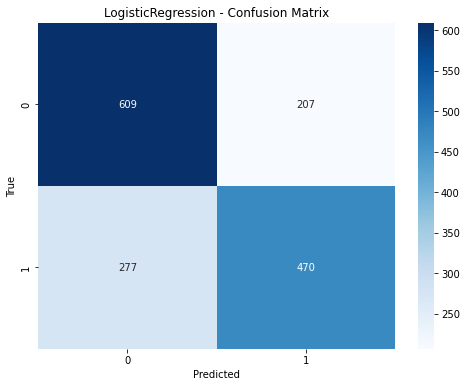

 
Model:  LogisticRegression
Train Accuracy:  0.69328
Test Accuracy:  0.6903390914907229
_________


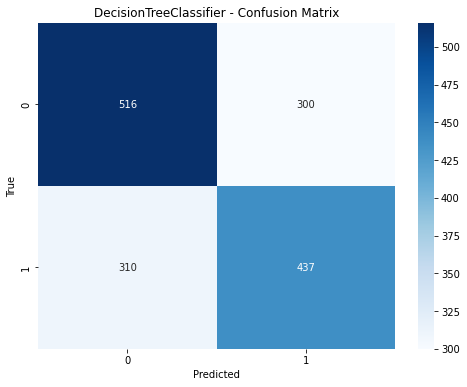

 
Model:  DecisionTreeClassifier
Train Accuracy:  0.6278400000000001
Test Accuracy:  0.6097248880358286
_________


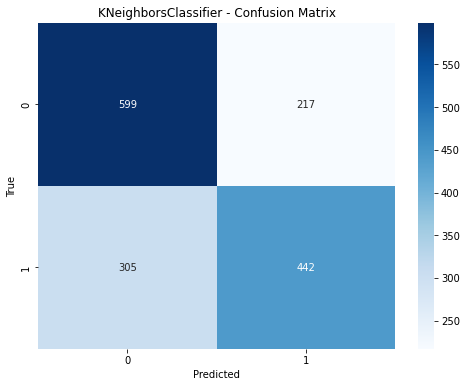

 
Model:  KNeighborsClassifier
Train Accuracy:  0.6624000000000001
Test Accuracy:  0.6660268714011516
_________


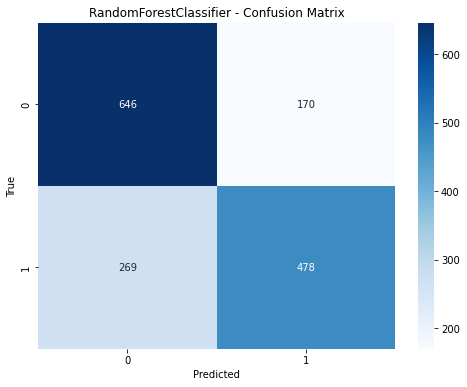

 
Model:  RandomForestClassifier
Train Accuracy:  0.71072
Test Accuracy:  0.7191298784388995
_________


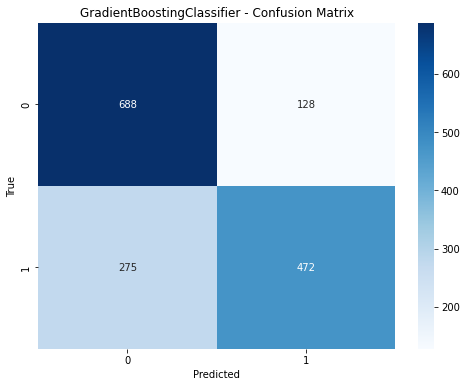

 
Model:  GradientBoostingClassifier
Train Accuracy:  0.72528
Test Accuracy:  0.7421625079974408
_________


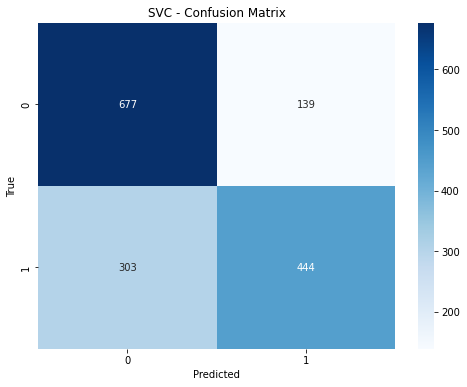

 
Model:  SVC
Train Accuracy:  0.69792
Test Accuracy:  0.7172104926423545
_________


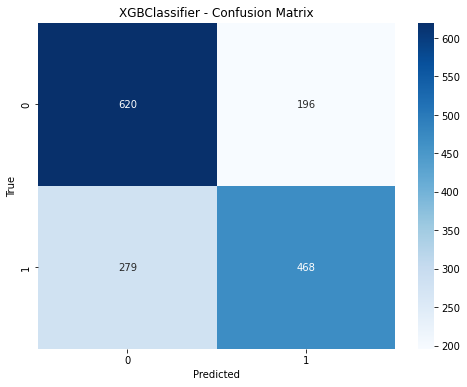

 
Model:  XGBClassifier
Train Accuracy:  0.6936
Test Accuracy:  0.6960972488803583
_________


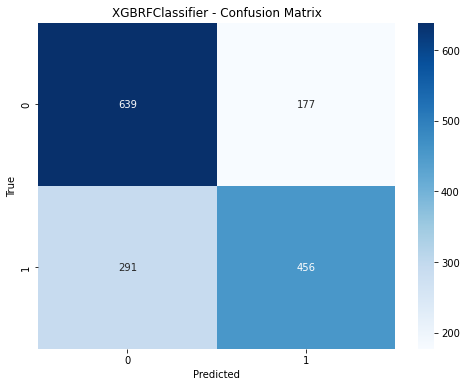

 
Model:  XGBRFClassifier
Train Accuracy:  0.7064
Test Accuracy:  0.7005758157389635
_________


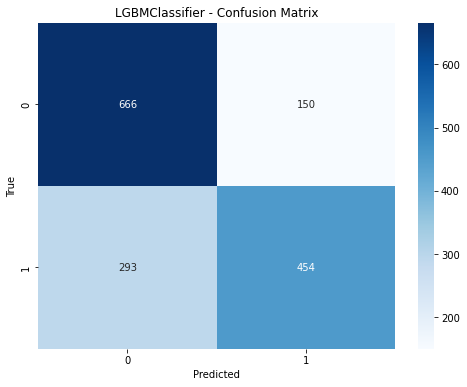

 
Model:  LGBMClassifier
Train Accuracy:  0.70912
Test Accuracy:  0.7165706973768394
_________


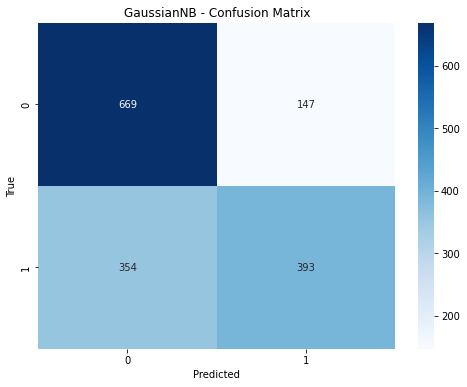

 
Model:  GaussianNB
Train Accuracy:  0.6504
Test Accuracy:  0.6794625719769674
_________


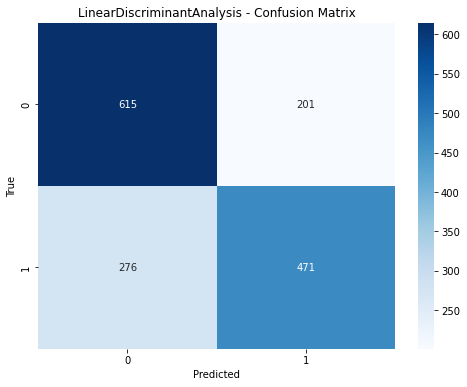

 
Model:  LinearDiscriminantAnalysis
Train Accuracy:  0.69136
Test Accuracy:  0.6948176583493282
_________


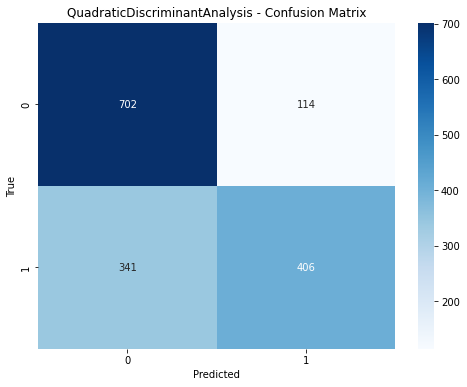

 
Model:  QuadraticDiscriminantAnalysis
Train Accuracy:  0.6856000000000001
Test Accuracy:  0.708893154190659
_________


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

logreg = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
svm = SVC(random_state=42)
xgb = XGBClassifier(random_state=42)
xgb_rf = XGBRFClassifier(random_state=42)
lgbm = LGBMClassifier(random_state=42)
nb = GaussianNB()
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

models = [logreg, dt, knn, rf, gb, svm, xgb, xgb_rf, lgbm, nb, lda, qda]
for model in models:
    ct = ColumnTransformer([
            ("Encoding", OneHotEncoder(drop='first'), ['contact', 'housing', 'loan', 'poutcome', 'contact_frequency']),
            ("Binary Encoding", ce.BinaryEncoder(), ['job', 'age_job', 'contact_month', 'poutcome_month']),
            ("Ordinal Encoding", OrdinalEncoder(), ['month', 'age_interval']),
            ("Scalling", RobustScaler(), ['balance', 'age', 'difference_balance_and_average','campaign', 'pdays', 'campaign_pdays', 'balance_age_ratio']) #Robust Scaler digunakan karena data outlier tetap digunakan
        ], remainder='passthrough', verbose_feature_names_out=False)

    clf = Pipeline([
            ("Feature Transformation", ct),
            (f"Model {type(model).__name__}", model)
        ])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_accuracy = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
    clf.fit(X_train, y_train)
    test_prediction = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_prediction)
    cm = confusion_matrix(y_test, test_prediction)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"{type(model).__name__} - Confusion Matrix")
    plt.show()
    print(" ")
    print("Model: ", type(model).__name__)
    print("Train Accuracy: ", train_accuracy.mean())
    print("Test Accuracy: ", test_accuracy)
    print("_________")

Dilakukan pemodelan pertama dengan penggunaan evaluation metrics berupa accuracy score dikarenakan dataset ini termasuk balanced dataset dan accuracy score ini menandakan persentase berapa hasil prediksi yang benar dibandingkan dengan data aktual baik pada value yes and no (1 dan 0) untuk pelanggan melakukan deposit atau tidak dimana pemilihan evaluation metrics ini sejalan dengan permasalahan yang ada dan bentuk dataset yang didapatkan karena pada bank marketing campaign ini sendiri, tentunya keakuratan prediksi untuk pelanggan melakukan deposit atau tidak merupakan hal yang diprioritaskan agar bank mampu melihat pelanggan yang tidak melakukan deposit berdasarkan model machine learning yang dibuat dan dapat diberikan perlakuan tambahan untuk pelanggan tersebut **sehingga dibutuhkan model machine learning yang mampu melakukan prediksi akurat untuk value yes and no (1 dan 0) pada variabel `deposit` dimana evaluation metrics paling tepat untuk hal ini adalah accuracy score.** Didapatkan bahwa semua model menghasilkan nilai yang serupa namun **model Gradient Boosting Classifier menghasilkan nilai accuracy pada data testing terbaik yakni 74,216 % sehingga algoritma Gradient Boosting Classifier inilah yang akan digunakan untuk pemberian perlakuan tambahan seperti hyperparameter tuning, feature selection, ensemble model, dan sebagainya dikarenakan akurasi ini masih dianggap cukup rendah. Dari hal ini, juga ditemukan bahwa permasalahan yang menurunkan nilai akurasi adalah dari sisi precision dimana hampir sebagian besar kesalahan dari prediksi mesin didapatkan ketika melakukan prediksi pada angka 1 dari variabel `deposit` sehingga hal ini menunjukkan permasalahan dari sisi `recall` dikarenakan angka false negative yang ditemukan (prediksi angka 0 dimana seharusnya angka 1 yang benar).**

# Identifying Problem On The Model

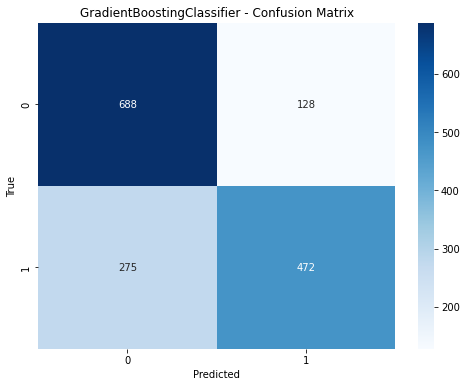

 
Model:  GradientBoostingClassifier
Train Accuracy:  0.72528
Test Accuracy:  0.7421625079974408
_________
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.84      0.77       816
           1       0.79      0.63      0.70       747

    accuracy                           0.74      1563
   macro avg       0.75      0.74      0.74      1563
weighted avg       0.75      0.74      0.74      1563



In [ ]:
from sklearn.metrics import classification_report

gb = GradientBoostingClassifier(random_state=42)
ct = ColumnTransformer([
            ("Encoding", OneHotEncoder(drop='first'), ['contact', 'housing', 'loan', 'poutcome', 'contact_frequency']),
             ("Binary Encoding", ce.BinaryEncoder(), ['job', 'age_job', 'contact_month', 'poutcome_month']),
            ("Ordinal Encoding", OrdinalEncoder(), ['month', 'age_interval']),
            ("Scalling", RobustScaler(), ['balance', 'age', 'difference_balance_and_average','campaign', 'pdays', 'campaign_pdays', 'balance_age_ratio']) #Robust Scaler digunakan karena data outlier tetap digunakan
        ], remainder='passthrough', verbose_feature_names_out=False)


clf = Pipeline([
        ("Feature Transformation", ct),
        (f"Model {type(gb).__name__}", gb)
    ])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_accuracy = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
clf.fit(X_train, y_train)
test_prediction = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, test_prediction)
cm = confusion_matrix(y_test, test_prediction)
classification_rep = classification_report(y_test, test_prediction)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f"{type(gb).__name__} - Confusion Matrix")
plt.show()

print(" ")
print("Model: ", type(gb).__name__)
print("Train Accuracy: ", train_accuracy.mean())
print("Test Accuracy: ", test_accuracy)
print("_________")
print("Classification Report:")
print(classification_rep)


Dapat dilihat permasalahan dari nilai precision yang rendah pada nilai 0, recall yang rendah pada nilai 1, dan f1 score yang rendah untuk nilai 1 dimana semua hal ini memperlihatkan bahwa machine learning model yang dibuat dengan algoritma ini sering melakukan prediksi nilai 0 walaupun angka yang benar seharusnya 1 dimana hal ini terlihat dari precision nilai 0 yang cukup rendah dimana precision sendiri merupakan rasio prediksi benar positif dibandingkan dengan keseluruhan hasil yang diprediksi positif. Terlihat juga dari nilai recall yang rendah untuk nilai 1 dikarenakan recall ini sendiri adalah  rasio prediksi benar positif dibandingkan dengan keseluruhan data yang benar positif dimana hal ini masuk akal karena **precision nilai 0 yang rendah menandakan bahwa banyak prediksi angka 0 yang salah dimana hal ini tentunya mengartikan banyak prediksi berupa 0 dimana hasil seharusnya adalah angka 1 sehingga recall untuk nilai 1 juga rendah. F1-score disini merupakan rata-rata dari nilai precision dan recall dimana tentunya didapatkan juga bahwa f1-score untuk nilai 1 didapatkan cukup rendah.** 

# Optimizing Selected Model

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3767           0.0075            9.11s
         2           1.3700           0.0071            7.50s
         3           1.3626           0.0068            7.85s
         4           1.3556           0.0065            7.55s
         5           1.3473           0.0066            7.65s
         6           1.3417           0.0058            7.42s
         7           1.3352           0.0056            7.14s
         8           1.3301           0.0055            7.04s
         9           1.3253           0.0057            6.88s
        10           1.3190           0.0052            6.79s
        20           1.2690           0.0032            6.71s
        30           1.2380           0.0022            6.61s
        40           1.2158           0.0022            6.58s
        50           1.1857           0.0010            6.40s
        60           1.1739           0.0009            6.16s
       

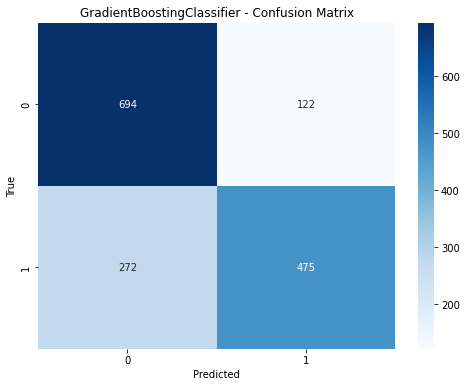

 
Model:  GradientBoostingClassifier
Train Accuracy:  0.72544
Test Accuracy:  0.7479206653870761
_________
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.85      0.78       816
           1       0.80      0.64      0.71       747

    accuracy                           0.75      1563
   macro avg       0.76      0.74      0.74      1563
weighted avg       0.76      0.75      0.74      1563



In [ ]:
gb = GradientBoostingClassifier(random_state=42, n_estimators=400, learning_rate = 0.02, min_samples_leaf= 3, subsample= 0.8, min_weight_fraction_leaf= 0.001, max_depth= 4, min_impurity_decrease= 0.0001 , max_leaf_nodes= 9 , verbose = 1)
ct = ColumnTransformer([
            ("Encoding", OneHotEncoder(drop='first'), ['contact', 'housing', 'loan', 'poutcome', 'contact_frequency']),
            ("Binary Encoding", ce.BinaryEncoder(), ['job','age_job', 'contact_month', 'poutcome_month']),
            ("Ordinal Encoding", OrdinalEncoder(), ['month', 'age_interval']),
            ("Scalling", RobustScaler(), ['balance', 'age', 'difference_balance_and_average','campaign', 'pdays', 'campaign_pdays', 'balance_age_ratio']) #Robust Scaler digunakan karena data outlier tetap digunakan
        ], remainder='passthrough', verbose_feature_names_out=False)


clf = Pipeline([
        ("Feature Transformation", ct),
        (f"Model {type(gb).__name__}", gb)
    ])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_accuracy = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
clf.fit(X_train, y_train)
test_prediction = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, test_prediction)
cm = confusion_matrix(y_test, test_prediction)
classification_rep = classification_report(y_test, test_prediction)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f"{type(gb).__name__} - Confusion Matrix")
plt.show()

print(" ")
print("Model: ", type(gb).__name__)
print("Train Accuracy: ", train_accuracy.mean())
print("Test Accuracy: ", test_accuracy)
print("_________")
print("Classification Report:")
print(classification_rep)


Proses ini diterapkan dengan mengatur beberapa parameter dari algoritma GradientBoostingClassifier dimana ditemukan bahwa terdapat improvement untuk nilai akurasi beserta precision, recall, dan f1-score. Parameter ini yang nantinya akan diterapkan hyperparameter tuning untuk mencari kombinasi parameter dengan nilai f1-score terbaik dikarenakan model ini memiliki **permasalahan dari sisi f1-score dimana f1-score ini merupakan sebuah nilai rata-rata dari precision dan recall.** Sebelum masuk ke tahap hyperparameter tuning, dilakukan feature selection terlebih dahulu dengan menggunakan SelectKBest.

# Feature Selection
Kita tidak dapat mengetahui berapa banyak feature yang seharusnya digunakan untuk mendapatkan hasil terbaik sehingga akan digunakan bantuan dari GridSearchCV untuk melakukan testing dari beberapa parameter untuk jumlah feature yang digunakan. 

In [ ]:
ct.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('Encoding', OneHotEncoder(drop='first'),
                                 ['contact', 'housing', 'loan', 'poutcome',
                                  'contact_frequency']),
                                ('Binary Encoding', BinaryEncoder(),
                                 ['job', 'age_job', 'contact_month',
                                  'poutcome_month']),
                                ('Ordinal Encoding', OrdinalEncoder(),
                                 ['month', 'age_interval']),
                                ('Scalling', RobustScaler(),
                                 ['balance', 'age',
                                  'difference_balance_and_average', 'campaign',
                                  'pdays', 'campaign_pdays',
                                  'balance_age_ratio'])],
                  verbose_feature_names_out=False)

In [ ]:
X_train_pre = ct.transform(X_train)
print(X_train_pre.shape)

(6250, 44)


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV

ct = ColumnTransformer([
            ("Encoding", OneHotEncoder(drop='first'), ['contact', 'housing', 'loan', 'poutcome', 'contact_frequency']),
             ("Binary Encoding", ce.BinaryEncoder(), ['job', 'age_job', 'contact_month', 'poutcome_month']),
            ("Ordinal Encoding", OrdinalEncoder(), ['month', 'age_interval']),
            ("Scalling", RobustScaler(), ['balance', 'age', 'difference_balance_and_average','campaign', 'pdays', 'campaign_pdays', 'balance_age_ratio']) #Robust Scaler digunakan karena data outlier tetap digunakan
        ], remainder='passthrough', verbose_feature_names_out=False)

fs = Pipeline([
        ('Feature Transformation', ct),
        ('Select', SelectKBest()),
        ("Model", GradientBoostingClassifier(random_state=42, n_estimators=400, learning_rate = 0.02, min_samples_leaf= 3, subsample= 0.8, min_weight_fraction_leaf= 0.001, max_depth= 4, min_impurity_decrease= 0.0001 , max_leaf_nodes= 9))
    ])

param_grid = {
        'Select__k':[ 38, 39, 40, 41, 42, 44]
    }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search_feature_selection = GridSearchCV(fs, param_grid=param_grid, scoring = 'f1', cv = cv, verbose = 4)
grid_search_feature_selection.fit(X_train, y_train)

print(f"Best Parameter Feature Selection :", grid_search_feature_selection.best_params_)
print(f"Best Parameter Feature Selection F1-Score:", grid_search_feature_selection.best_score_)
test_accuracy = grid_search_feature_selection.best_estimator_.score(X_test, y_test)
print(f"Best Parameter Feature Selection Test Accuracy:", test_accuracy)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ......................Select__k=38;, score=0.678 total time=   5.8s
[CV 2/5] END ......................Select__k=38;, score=0.671 total time=   4.9s
[CV 3/5] END ......................Select__k=38;, score=0.675 total time=   4.7s
[CV 4/5] END ......................Select__k=38;, score=0.667 total time=   4.9s
[CV 5/5] END ......................Select__k=38;, score=0.716 total time=   4.9s
[CV 1/5] END ......................Select__k=39;, score=0.682 total time=   5.1s
[CV 2/5] END ......................Select__k=39;, score=0.664 total time=   4.7s
[CV 3/5] END ......................Select__k=39;, score=0.674 total time=   4.5s
[CV 4/5] END ......................Select__k=39;, score=0.669 total time=   4.3s
[CV 5/5] END ......................Select__k=39;, score=0.719 total time=   4.0s
[CV 1/5] END ......................Select__k=40;, score=0.676 total time=   4.8s
[CV 2/5] END ......................Select__k=40;,

Dapat dilihat bahwa hasil terbaik didapatkan dari tidak adanya penghapusan feature dan terlihat bahwa **f1-score yang diperoleh berbeda dengan f1-score yang terdapat pada f1-score sebelumnya yang terdapat pada classification report. Hal ini disebabkan karena f1-score yang ditampilkan disini merupakan f1-score dari GridSearch dan juga f1-score ini didapatkan untuk data training, sedangkan f1-score pada classification report merupakan hasil dari data testing.**

# Hyperparameter Tuning Model Terbaik

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END Model__learning_rate=0.02, Model__loss=log_loss, Model__max_depth=3, Model__max_leaf_nodes=9, Model__min_impurity_decrease=0.0001, Model__min_samples_leaf=4, Model__min_weight_fraction_leaf=0.001, Model__n_estimators=400, Model__subsample=0.8;, score=0.674 total time=   4.2s
[CV 2/5] END Model__learning_rate=0.02, Model__loss=log_loss, Model__max_depth=3, Model__max_leaf_nodes=9, Model__min_impurity_decrease=0.0001, Model__min_samples_leaf=4, Model__min_weight_fraction_leaf=0.001, Model__n_estimators=400, Model__subsample=0.8;, score=0.668 total time=   4.1s
[CV 3/5] END Model__learning_rate=0.02, Model__loss=log_loss, Model__max_depth=3, Model__max_leaf_nodes=9, Model__min_impurity_decrease=0.0001, Model__min_samples_leaf=4, Model__min_weight_fraction_leaf=0.001, Model__n_estimators=400, Model__subsample=0.8;, score=0.671 total time=   4.0s
[CV 4/5] END Model__learning_rate=0.02, Model__loss=log_loss, Model__ma

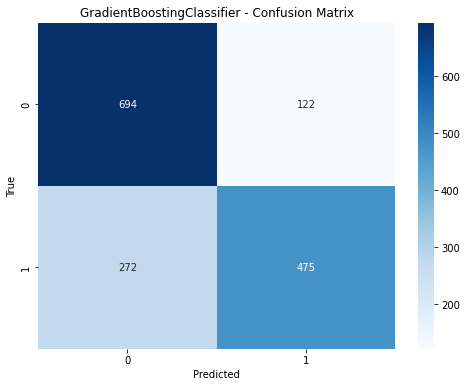

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.85      0.78       816
           1       0.80      0.64      0.71       747

    accuracy                           0.75      1563
   macro avg       0.76      0.74      0.74      1563
weighted avg       0.76      0.75      0.74      1563

 
Best Parameters GBC:  {'Model__learning_rate': 0.02, 'Model__loss': 'log_loss', 'Model__max_depth': 4, 'Model__max_leaf_nodes': 9, 'Model__min_impurity_decrease': 0.0001, 'Model__min_samples_leaf': 4, 'Model__min_weight_fraction_leaf': 0.001, 'Model__n_estimators': 400, 'Model__subsample': 0.8}
F1-Score Best Parameters GBC:  0.6818414721648602
Test Accuracy Best Parameters GBC:  0.7479206653870761
_________


In [ ]:
ct = ColumnTransformer([
            ("Encoding", OneHotEncoder(drop='first'), ['contact', 'housing', 'loan', 'poutcome', 'contact_frequency']),
             ("Binary Encoding", ce.BinaryEncoder(), ['job', 'age_job', 'contact_month', 'poutcome_month']),
            ("Ordinal Encoding", OrdinalEncoder(), ['month', 'age_interval']),
            ("Scalling", RobustScaler(), ['balance', 'age', 'difference_balance_and_average','campaign', 'pdays', 'campaign_pdays', 'balance_age_ratio']) #Robust Scaler digunakan karena data outlier tetap digunakan
        ], remainder='passthrough', verbose_feature_names_out=False)

gbc = GradientBoostingClassifier(random_state=42)
GradientBoostingClassifier(random_state=42, min_samples_leaf= 3 ,subsample= 0.8, min_impurity_decrease= 0.0001 , max_leaf_nodes= 9)
pipe = Pipeline([
    ("Feature Transformation", ct),
    ('Select', SelectKBest(k = 44)),
    ("Model", gbc)
])

param_grid = {
    'Model__learning_rate': [0.02, 0.025],
    'Model__n_estimators': [400, 500],
    'Model__max_depth': [3, 4, 5],
    'Model__min_weight_fraction_leaf':[0.001],
    'Model__min_samples_leaf':[4],
    'Model__subsample':[0.8],
    'Model__min_impurity_decrease':[0.0001],
    'Model__max_leaf_nodes':[9],
    'Model__loss':['log_loss', 'exponential'],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Perform grid search
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='f1',  verbose=4)
grid_search.fit(X_train, y_train)

# Get the best model
best_ens = grid_search.best_estimator_

# Evaluate the best model on the test set
test_prediction = best_ens.predict(X_test)
test_accuracy = accuracy_score(y_test, test_prediction)
cm = confusion_matrix(y_test, test_prediction)
classification_rep = classification_report(y_test, test_prediction)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f"{type(gb).__name__} - Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_rep)

print(" ")
print("Best Parameters GBC: ", grid_search.best_params_)
print("F1-Score Best Parameters GBC: ", grid_search.best_score_)
print("Test Accuracy Best Parameters GBC: ", test_accuracy)
print("_________")


Dari hal ini, dapat dilihat bahwa metode hyperparameter tuning tetap mendapatkan hasil terbaik seperti sebelumnya untuk parameter f1-score dimana model ini menjadi model yang dipilih dan akan dideploy melalui pickle. **Alasan pemilihan f1-score ini sendiri adalah karena permasalahan dari model yang telah dibuat sebelumnya merupakan angka f1-score yang rendah dan juga dapat dilihat ketika terdapat peningkatan angka f1-score, akurasi pada data test juga meningkat sehingga metode hyperparameter tuning ini sendiri bertujuan untuk mengurangi permasalahan pada angka f1-score.**

In [ ]:
selected_features = []
for transformer_name, transformer, columns in best_ens.named_steps['Feature Transformation'].transformers_:
    if hasattr(transformer, 'get_feature_names_out'):
        if transformer_name == 'Binary Encoding':
            feature_names = ['x'+name for name in transformer.get_feature_names_out()]
        else:
            feature_names = transformer.get_feature_names_out()
        selected_features.extend(feature_names)
    else:
        selected_features.extend(columns)
importance_df = pd.DataFrame({'Feature': selected_features})
feature_importances = best_ens.named_steps['Model'].feature_importances_
importance_df['Importance'] = feature_importances
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                                   Feature  Importance
5                         poutcome_success    0.220543
1                          contact_unknown    0.143432
34                                   month    0.105513
43                                      12    0.085019
37                                     age    0.077905
42                       balance_age_ratio    0.064246
40                                   pdays    0.044519
39                                campaign    0.037722
36                                 balance    0.033827
38          difference_balance_and_average    0.031747
41                          campaign_pdays    0.016359
24                        xcontact_month_2    0.015621
29                       xpoutcome_month_1    0.012451
0                        contact_telephone    0.011931
25                        xcontact_month_3    0.010117
23                        xcontact_month_1    0.010010
28                       xpoutcome_month_0    0.008761
31        

In [ ]:
X_test.shape

(1563, 19)

In [ ]:
df_X_test = X_test.reset_index(drop=True)

In [ ]:
df_test = pd.concat([df_X_test, pd.Series(test_prediction, name='Predicted')], axis=1)

In [ ]:
df_test

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,contact_frequency,age_interval,debt,difference_balance_and_average,poutcome_month,age_job,contact_month,balance_age_ratio,campaign_pdays,Predicted
0,32,management,-383,yes,no,unknown,may,1,0,unknown,Rarely Contacted,28 - 32,1,1895.448611,unknown_may,32_management,unknown_may,-11.968750,0,0
1,37,services,608,no,no,cellular,may,3,0,unknown,Moderately Contacted,33 - 37,0,904.448611,unknown_may,37_services,cellular_may,16.432432,0,1
2,31,admin.,-422,yes,no,cellular,may,2,329,other,Rarely Contacted,28 - 32,1,1934.448611,other_may,31_admin.,cellular_may,-13.612903,-658,0
3,30,blue-collar,128,yes,no,unknown,may,1,0,unknown,Rarely Contacted,28 - 32,1,1384.448611,unknown_may,30_blue-collar,unknown_may,4.266667,0,0
4,56,management,7747,no,no,unknown,jun,2,0,unknown,Rarely Contacted,53 - 57,0,6234.551389,unknown_jun,56_management,unknown_jun,138.339286,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,41,technician,30,yes,no,cellular,jul,1,0,unknown,Rarely Contacted,38 - 42,1,1482.448611,unknown_jul,41_technician,cellular_jul,0.731707,0,0
1559,30,management,398,no,no,cellular,apr,2,0,unknown,Rarely Contacted,28 - 32,0,1114.448611,unknown_apr,30_management,cellular_apr,13.266667,0,1
1560,45,management,80,no,yes,cellular,nov,1,0,unknown,Rarely Contacted,43 - 47,1,1432.448611,unknown_nov,45_management,cellular_nov,1.777778,0,0
1561,46,admin.,5511,no,no,cellular,jul,2,389,success,Rarely Contacted,43 - 47,0,3998.551389,success_jul,46_admin.,cellular_jul,119.804348,-778,1


In [ ]:
df_test.groupby('poutcome')['Predicted'].value_counts(normalize = True)

poutcome  Predicted
failure   0            0.535948
          1            0.464052
other     1            0.528736
          0            0.471264
success   1            1.000000
unknown   0            0.721129
          1            0.278871
Name: Predicted, dtype: float64

Dapat dilihat bahwa dari feature importance, poutcome_success itu sendiri memiliki 22 % pengaruh untuk prediksi dari machine learning model yang dibuat dan dari hasil ini, juga dilihat bahwa semua prediksi yang dihasilkan merupakan angka 1 untuk poutcome_success **sehingga dapat disimpulkan bahwa poutcome_success ini memiliki pengaruh besar untuk menghasilkan prediksi berupa 1 yakni customer melakukan deposit. Perlu diberikan prioritas juga untuk poutcome_unknown dimana sekitar 72 % data yang memiliki poutcome_unknown diprediksi menghasilkan value 0 yakni customer tidak melakukan deposit sehingga hal ini juga dapat dijadikan dasar oleh bank untuk memprioritaskan customer dengan data poutcome_unknown**

In [ ]:
df_test.groupby('contact')['Predicted'].value_counts()

contact    Predicted
cellular   0            593
           1            526
telephone  1             63
           0             55
unknown    0            318
           1              8
Name: Predicted, dtype: int64

In [ ]:
df_test.groupby('contact')['Predicted'].value_counts(normalize = True)

contact    Predicted
cellular   0            0.529937
           1            0.470063
telephone  1            0.533898
           0            0.466102
unknown    0            0.975460
           1            0.024540
Name: Predicted, dtype: float64

Dapat dilihat bahwa dari feature importance, contact_unknown itu sendiri memiliki 14 % pengaruh untuk prediksi dari machine learning model yang dibuat dan dari hasil ini, juga dilihat bahwa sekitar 97 % dari prediksi yang dihasilkan berupa angka 0 untuk contact_unknown **sehingga dapat disimpulkan bahwa poutcome_unknown ini memliki pengaruh besar untuk menghasilkan prediksi berupa 0 yakni customer tidak melakukan deposit sehingga hal ini juga dapat dijadikan dasar oleh bank untuk memprioritaskan customer dengan data contact_unknown.**

In [ ]:
df_test.groupby('month')['Predicted'].value_counts(normalize = True)

month  Predicted
apr    1            0.620690
       0            0.379310
aug    0            0.658879
       1            0.341121
dec    1            1.000000
feb    1            0.594595
       0            0.405405
jan    0            0.622222
       1            0.377778
jul    0            0.796537
       1            0.203463
jun    0            0.708075
       1            0.291925
mar    1            0.976190
       0            0.023810
may    0            0.836412
       1            0.163588
nov    0            0.640000
       1            0.360000
oct    1            1.000000
sep    1            0.968750
       0            0.031250
Name: Predicted, dtype: float64

Month ini merupakan data bulan terakhir customer dicontact dimana month ini sendiri memiliki 10 % pengaruh untuk prediksi dari model machine learning yang dibuat, dan dapat dilihat bahwa bulan april, agustus, januari, juli, juni, mei, dan november ini lebih cenderung menghasilkan prediksi nilai 0 yakni customer tidak melakukan deposit. **Hal ini dapat dijadikan dasar oleh bank untuk memprioritaskan customer yang dicontact pada bulan-bulan yang termasuk bulan yang disebutkan diatas.**

In [ ]:
months_to_filter = ['apr', 'aug', 'jan', 'jul', 'jun', 'may', 'nov']
df_test[df_test['month'].isin(months_to_filter)]['Predicted'].value_counts(normalize=True)

0    0.706923
1    0.293077
Name: Predicted, dtype: float64

In [ ]:
df_test[~df_test['month'].isin(months_to_filter)][ 'Predicted'].value_counts(normalize=True)

1    0.821293
0    0.178707
Name: Predicted, dtype: float64

Dapat dilihat bahwa perbedaan untuk hasil prediksi value 1 yakni customer melakukan deposit memiliki perbedaan sekitar 53 % antara customer yang dicontact pada bulan-bulan yang termasuk dan yang tidak termasuk dari bulan yang disebutkan diatas.

# Conclusion and Recommendation

<h3> Conclusion </h3>

Dari model machine learning yang telah dibuat, dapat ditarik beberapa kesimpulan yakni sebagai berikut :
* Model machine learning dengan algoritma GradientBoostingClassifier mampu menghasilkan akurasi untuk prediksi data testing sebesar 74,79 %.
* Dari feature importance, dapat dilihat bahwa feature poutcome_success, contact_unknown, dan month merupakan 3 feature dengan tingkat pengaruh terbesar untuk prediksi yang dihasilkan oleh model machine learning.
* Kelemahan terbesar dari model machine learning yang dibuat adalah machine learning sering melakukan kesalahan pada untuk prediksi customer melakukan deposit (angka 1) dimana hasil seharusnya adalah customer tidak melakukan deposit (angka 0).
* Apabila dilihat dari tingkat akurasi dan kelemahan terbesar dari model machine learning, data feature importance yang masih dapat dipercaya merupakan data-data dengan nilai importance besar (lebih dari 10 %) dikarenakan data-data dengan nilai importance besar ini tidak akan berubah dengan drastis sehingga nilai importance yang dihasilkan masih dapat terhitung besar apabila model machine learning ini dapat ditingkatkan untuk tingkat akurasi dari prediksinya.
* contact_unknown memiliki 14 % pengaruh untuk prediksi dari machine learning model yang dibuat dan dari hasil ini, juga dilihat bahwa sekitar 97 % dari prediksi yang dihasilkan berupa customer tidak melakukan deposit (angka 0) untuk contact_unknown.
* poutcome_success memiliki 22 % pengaruh untuk prediksi dari machine learning model yang dibuat dan dari hasil ini, juga dilihat bahwa semua prediksi yang dihasilkan merupakan angka 1 untuk poutcome_success.
* Sekitar 72 % data yang memiliki poutcome_unknown diprediksi menghasilkan value 0 yakni customer tidak melakukan deposit.
* month ini memiliki 10 % pengaruh untuk prediksi dari model machine learning yang dibuat, dan dapat dilihat bahwa bulan april, agustus, januari, juli, juni, mei, dan november ini lebih cenderung menghasilkan prediksi nilai 0 yakni customer tidak melakukan deposit.

<h3> Recommendation </h3>
Dari kesimpulan diatas, dapat ditarik beberapa rekomendasi yakni sebagai berikut :

* Bank dapat memberikan perlakuan khusus untuk customer yang memiliki data contact_unknown, poutcome_success, dan yang memiliki bulan terakhir contact yang termasuk pada april, agustus, januari, juli, juni, mei, dan november untuk memperbesar kemungkinan customer dalam melakukan deposit.
* Sebaiknya bank menerapkan standarisasi prosedur contact customer menggunakan telephone atau cellular dimana terlihat dari data contact_unknown yang 97 % diprediksikan untuk menghasilkan value 0 yakni customer tidak melakukan deposit sedangkan penggunaan telephone atau cellular memiliki angka sekitar 50 % untuk prediksi value 1 ataupun 0 dimana apabila dilihat dari angka hasil prediksi untuk contact unknown yakni 318 customer diprediksi tidak melakukan deposit dapat dikurangi sekitar 50 % apabila menggunakan telephone atau cellular sehingga berpotensi menambah sekitar 159 customer yang melakukan prediksi (dari proporsi data testing yang diprediksi sebesar 1563, maka diperkirakan rekomendasi ini mampu meningkatkan sekitar 10 % jumlah customer yang melakukan deposit).
* Sebaiknya, bank melakukan contact customer pada bulan-bulan yang tidak termasuk pada bulan april, agustus, januari, juli, juni, mei, dan november dimana hal ini berpotensi untuk meningkatkan sekitar 53 % untuk jumlah customer yang melakukan deposit berdasarkan hasil prediksi model machine learning yang ada.


# Deployment

In [ ]:
import pickle
model_filepath = 'Capstone_Project_Modul3_model.pkl'

with open(model_filepath, 'wb') as file:
    pickle.dump(best_ens, file)